In [46]:
import pandas as pd #For reading csv files.
import numpy as np 
import matplotlib.pyplot as plt #For plotting.

import PIL.Image as Image #For working with image files.

#Importing torch
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset,DataLoader #For working with data.

from torchvision import models,transforms, datasets #For pretrained models,image transformations.

import random
random.seed(99)
torch.manual_seed(99)
np.random.seed(99)

In [47]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #Use GPU if it's available or else use CPU.
print(device) #Prints the device we're using.

cuda


In [48]:
path = "Canula"

import pathlib
data_dir = "Canula"
print(data_dir)
data_dir = pathlib.Path(data_dir)

image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

no_bones = list(data_dir.glob('no_bone/*'))
with_bones = list(data_dir.glob('bone/*'))

train_data = datasets.ImageFolder(data_dir)

# train_df = pd.read_csv(f"{path}train.csv")
# print(f'No.of.training_samples: {len(train_df)}')


Canula
269


In [49]:
train_data

Dataset ImageFolder
    Number of datapoints: 269
    Root location: Canula

In [50]:
idx2class = {v: k for k, v in train_data.class_to_idx.items()}

Text(0.5, 1.0, 'Entire Dataset (before train/val/test split)')

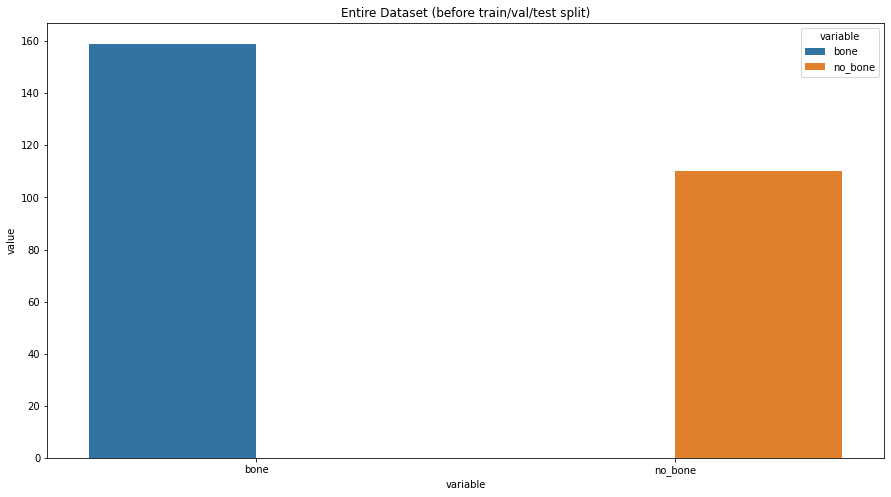

In [51]:
import seaborn as sns
def get_class_distribution(dataset_obj):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    for _, label_id in dataset_obj:
        label = idx2class[label_id]
        count_dict[label] += 1
    return count_dict
def plot_from_dict(dict_obj, plot_title, **kwargs):
    return sns.barplot(data = pd.DataFrame.from_dict([dict_obj]).melt(), x = "variable", y="value", hue="variable", **kwargs).set_title(plot_title)
plt.figure(figsize=(15,8))
plot_from_dict(get_class_distribution(train_data), plot_title="Entire Dataset (before train/val/test split)")

In [52]:
train_data_size = len(train_data)
train_dataset_indices = list(range(train_data_size))

In [53]:
np.random.shuffle(train_dataset_indices)

In [54]:
val_split_index = int(np.floor(0.2 * train_data_size))

In [55]:
train_idx, val_idx = train_dataset_indices[val_split_index:], train_dataset_indices[:val_split_index]
train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
val_sampler = torch.utils.data.SubsetRandomSampler(val_idx)

In [59]:
test_dataset = datasets.ImageFolder(root = "TestImg")
transform = transforms.Compose([transforms.ToTensor()])

In [61]:
train_loader = DataLoader(dataset=train_data, shuffle=False, batch_size=8, sampler=train_sampler)
val_loader = DataLoader(dataset=train_data, shuffle=False, batch_size=1, sampler=val_sampler)
test_loader = DataLoader(dataset=test_dataset, shuffle=False, batch_size=1)

In [62]:
print(f"Train dataset size: {len(train_idx)}")
print(f"Validation dataset size: {len(val_idx)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 216
Validation dataset size: 53
Test dataset size: 40


Text(0.5, 1.0, 'Entire Dataset (before train/val/test split)')

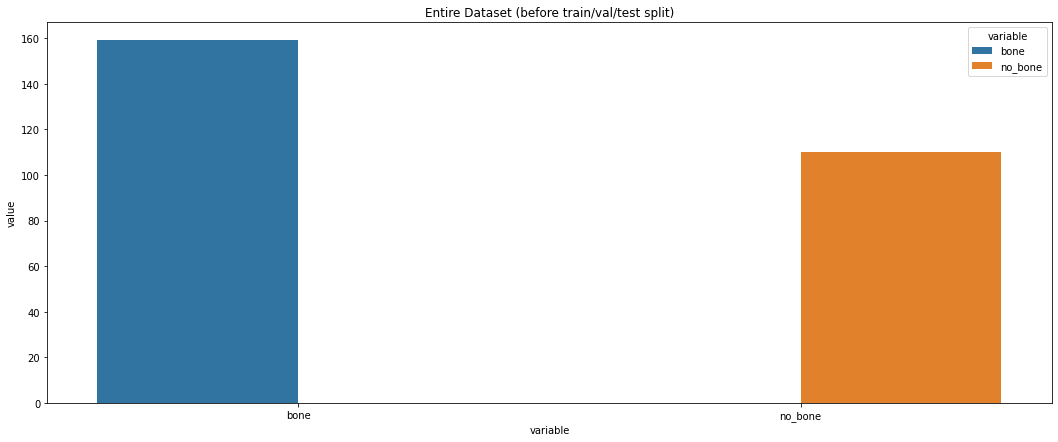

In [63]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(18,7))
plot_from_dict(get_class_distribution(train_data), plot_title="Entire Dataset (before train/val/test split)", ax=axes)

In [24]:
dir(train_loader)
train_loader.__dict__

{'dataset': Dataset ImageFolder
     Number of datapoints: 269
     Root location: Canula,
 'num_workers': 0,
 'prefetch_factor': 2,
 'pin_memory': False,
 'pin_memory_device': '',
 'timeout': 0,
 'worker_init_fn': None,
 '_DataLoader__multiprocessing_context': None,
 '_dataset_kind': 0,
 'batch_size': 8,
 'drop_last': False,
 'sampler': <torch.utils.data.sampler.SubsetRandomSampler at 0x7fdfcdc53c70>,
 'batch_sampler': <torch.utils.data.sampler.BatchSampler at 0x7fdfcdc53eb0>,
 'generator': None,
 'collate_fn': <function torch.utils.data._utils.collate.default_collate(batch)>,
 'persistent_workers': False,
 '_DataLoader__initialized': True,
 '_IterableDataset_len_called': None,
 '_iterator': None}

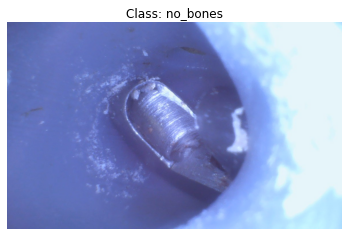

In [64]:
#For getting a random image from our training set.
num = int(np.random.randint(0,len(no_bones)-1,(1,))) #Picks a random number.
sample_image = no_bones[num]#Image file.
sample_image = Image.open(sample_image) 
plt.imshow(sample_image)
plt.axis('off')
plt.title(f'Class: no_bones') #Class of the random image.
plt.show()

In [65]:
class dataset(Dataset): # Inherits from the Dataset class.
    '''
    dataset class overloads the __init__, __len__, __getitem__ methods of the Dataset class. 
    
    Attributes :
        df:  DataFrame object for the csv file.
        data_path: Location of the dataset.
        image_transform: Transformations to apply to the image.
        train: A boolean indicating whether it is a training_set or not.
    '''
    
    def __init__(self,df,data_path,image_transform=None,train=True): # Constructor.
        super(Dataset,self).__init__() #Calls the constructor of the Dataset class.
        self.df = df
        self.data_path = data_path
        self.image_transform = image_transform
        self.train = train
        
    def __len__(self):
        return len(self.df) #Returns the number of samples in the dataset.
    
    def __getitem__(self,index):
        image_id = self.df['id_code'][index]
        image = Image.open(f'{self.data_path}/{image_id}.png') #Image.
        if self.image_transform :
            image = self.image_transform(image) #Applies transformation to the image.
        
        if self.train :
            label = self.df['diagnosis'][index] #Label.
            return image,label #If train == True, return image & label.
        
        else:
            return image #If train != True, return image.

In [68]:
image_transform = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]) #Transformations to apply to the image.
data_set = dataset(train_data,f'{path}train_images',image_transform=image_transform)

#Split the data_set so that valid_set contains 0.1 samples of the data_set. 
train_set,valid_set = torch.utils.data.random_split(data_set,[216,53])

In [69]:
len(train_set)

216

In [70]:
train_dataloader = DataLoader(train_set,batch_size=32,shuffle=True) #DataLoader for train_set.
valid_dataloader = DataLoader(valid_set,batch_size=32,shuffle=False) #DataLoader for validation_set.

In [71]:
#Since we've less data, we'll use Transfer learning.
model = models.resnet34(pretrained=True) #Downloads the resnet34 model which is pretrained on Imagenet dataset.

#Replace the Final layer of pretrained resnet34 with 4 new layers.
model.fc = nn.Sequential(nn.Linear(512,256),
                         nn.ReLU(inplace=True),
                         nn.Linear(256,128),
                         nn.ReLU(inplace=True),
                         nn.Linear(128,64),
                         nn.ReLU(inplace=True),
                         nn.Linear(64,2),    
                    )

/home/veysiadn/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/veysiadn/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [72]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [73]:
model = model.to(device) #Moves the model to the device.

In [78]:
def train(dataloader,model,loss_fn,optimizer):
    '''
    train function updates the weights of the model based on the
    loss using the optimizer in order to get a lower loss.
    
    Args :
         dataloader: Iterator for the batches in the data_set.
         model: Given an input produces an output by multiplying the input with the model weights.
         loss_fn: Calculates the discrepancy between the label & the model's predictions.
         optimizer: Updates the model weights.
         
    Returns :
         Average loss per batch which is calculated by dividing the losses for all the batches
         with the number of batches.
    '''

    model.train() #Sets the model for training.
    
    total = 0
    correct = 0
    running_loss = 0
    
    for batch,(x,y) in enumerate(dataloader): #Iterates through the batches.
        
        output = model(x.to(device)) #model's predictions.
        loss   = loss_fn(output,y.to(device)) #loss calculation.
       
        running_loss += loss.item()
        
        total        += y.size(0)
        predictions   = output.argmax(dim=1).cpu().detach() #Index for the highest score for all the samples in the batch.
        correct      += (predictions == y.cpu().detach()).sum().item() #No.of.cases where model's predictions are equal to the label.
        
        optimizer.zero_grad() #Gradient values are set to zero.
        loss.backward() #Calculates the gradients.
        optimizer.step() #Updates the model weights.
             
    
    avg_loss = running_loss/len(dataloader) # Average loss for a single batch
    
    print(f'\nTraining Loss = {avg_loss:.6f}',end='\t')
    print(f'Accuracy on Training set = {100*(correct/total):.6f}% [{correct}/{total}]') #Prints the Accuracy.
    
    return avg_loss

In [75]:
def validate(dataloader,model,loss_fn):
    '''
    validate function calculates the average loss per batch and the accuracy of the model's predictions.
    
    Args :
         dataloader: Iterator for the batches in the data_set.
         model: Given an input produces an output by multiplying the input with the model weights.
         loss_fn: Calculates the discrepancy between the label & the model's predictions.
    
    Returns :
         Average loss per batch which is calculated by dividing the losses for all the batches
         with the number of batches.
    '''
    
    model.eval() #Sets the model for evaluation.
    
    total = 0
    correct = 0
    running_loss = 0
    
    with torch.no_grad(): #No need to calculate the gradients.
        
        for x,y in dataloader:
            
            output        = model(x.to(device)) #model's output.
            loss          = loss_fn(output,y.to(device)).item() #loss calculation.
            running_loss += loss
            
            total        += y.size(0)
            predictions   = output.argmax(dim=1).cpu().detach()
            correct      += (predictions == y.cpu().detach()).sum().item()
            
    avg_loss = running_loss/len(dataloader) #Average loss per batch.      
    
    print(f'\nValidation Loss = {avg_loss:.6f}',end='\t')
    print(f'Accuracy on Validation set = {100*(correct/total):.6f}% [{correct}/{total}]') #Prints the Accuracy.
    
    return avg_loss

In [76]:
def optimize(train_dataloader,valid_dataloader,model,loss_fn,optimizer,nb_epochs):
    '''
    optimize function calls the train & validate functions for (nb_epochs) times.
    
    Args :
        train_dataloader: DataLoader for the train_set.
        valid_dataloader: DataLoader for the valid_set.
        model: Given an input produces an output by multiplying the input with the model weights.
        loss_fn: Calculates the discrepancy between the label & the model's predictions.
        optimizer: Updates the model weights.
        nb_epochs: Number of epochs.
        
    Returns :
        Tuple of lists containing losses for all the epochs.
    '''
    #Lists to store losses for all the epochs.
    train_losses = []
    valid_losses = []

    for epoch in range(nb_epochs):
        print(f'\nEpoch {epoch+1}/{nb_epochs}')
        print('-------------------------------')
        train_loss = train(train_dataloader,model,loss_fn,optimizer) #Calls the train function.
        train_losses.append(train_loss)
        valid_loss = validate(valid_dataloader,model,loss_fn) #Calls the validate function.
        valid_losses.append(valid_loss)
    
    print('\nTraining has completed!')
    
    return train_losses,valid_losses

## TRAIN AND VALIDATION RUN

In [79]:
loss_fn   = nn.CrossEntropyLoss() #CrossEntropyLoss with class_weights.
optimizer = torch.optim.Adam(model.parameters(),lr=0.001) 
nb_epochs = 30
#Call the optimize function.
train_losses, valid_losses = optimize(train_dataloader,valid_dataloader,model,loss_fn,optimizer,nb_epochs)


Epoch 1/30
-------------------------------


TypeError: list indices must be integers or slices, not str

In [ ]:
#Plot the graph of train_losses & valid_losses against nb_epochs.
epochs = range(nb_epochs)
plt.plot(epochs, train_losses, 'g', label='Training loss')
plt.plot(epochs, valid_losses, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
torch.save(model.state_dict(), 'diabetic_dict_saturday.pth')

In [ ]:
torch.save(model, "Diabetic_retinopath_saved.pth")

In [ ]:
!pip install -U onnxruntime
!pip install onnx

## IMPORT ONNX AND TEST


In [ ]:
pytorch_model = model
pytorch_model.load_state_dict(torch.load('diabetic_dict_saturday.pth'))
pytorch_model.eval()
dummy_input = torch.zeros(1,3,512,512).to(device)
torch.onnx.export(pytorch_model, dummy_input, 'diabetic_sunday.onnx', verbose=True)


In [ ]:
import onnx

# Load the ONNX model
model = onnx.load("diabetic_sunday.onnx")

# Check that the model is well formed
onnx.checker.check_model(model)

# Print a human readable representation of the graph
print(onnx.helper.printable_graph(model.graph))

In [ ]:
test_df = pd.read_csv(f'{path}test2.csv')
print(f'No.of.testing_samples: {len(test_df)}')

image_transform = transforms.Compose([transforms.Resize([512,512]),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

In [ ]:
class testdataset(Dataset): # Inherits from the Dataset class.
    '''
    dataset class overloads the __init__, __len__, __getitem__ methods of the Dataset class. 
    
    Attributes :
        df:  DataFrame object for the csv file.
        data_path: Location of the dataset.
        image_transform: Transformations to apply to the image.
        train: A boolean indicating whether it is a training_set or not.
    '''
    
    def __init__(self,df,data_path,image_transform=None,train=True): # Constructor.
        super(Dataset,self).__init__() #Calls the constructor of the Dataset class.
        self.df = df
        self.data_path = data_path
        self.image_transform = image_transform
        self.train = train
        
    def __len__(self):
        return len(self.df) #Returns the number of samples in the dataset.
    
    def __getitem__(self,index):
        image_id = self.df['id_code'][index]
        image = Image.open(f'{self.data_path}/{image_id}.png') #Image.
        if self.image_transform :
            image = self.image_transform(image) #Applies transformation to the image.
        
        if self.train :
            label = self.df['diagnosis'][index] #Label.
            return image,label #If train == True, return image & label.
        
        else:
            return image #If train != True, return image.

In [ ]:
import onnxruntime as ort
from matplotlib import pyplot as plt

In [ ]:
import imageio
import glob

test_image_list = glob.glob("aptos2019-blindness-detection//test_image//*_resized.png")
images1 = imageio.imread(test_image_list[0])
test_image_list

In [ ]:
test_set = testdataset(test_df,f'{path}test_image',image_transform = image_transform,train = False )

test_dataloader = DataLoader(test_set, batch_size=1, shuffle=False) #DataLoader for test_set.
for x,y in enumerate(test_dataloader):
    
    
    ort_session = ort.InferenceSession("diabetic_sunday.onnx")

    outputs = ort_session.run(
        None,
        {"input.1": y.cpu().detach().numpy()
    },
    )
    
    images = imageio.imread(test_image_list[x])
    plt.imshow(images)
    plt.show()
  
    
    predictions = outputs[0].argmax() #Predicted labels for an image batch.
    print(f"Prediction for {x+1}st image : {predictions}")
